# 学习了MCP服务器和客户端的搭建，以及用LangGraph框架配置MCP服务

# FastMCP--构建MCP服务器和客户端的快速Python方式。

https://gofastmcp.com/getting-started/welcome


## 安装FastMCP

https://gofastmcp.com/getting-started/installation

```
pip install fastmcp
```

## 验证安装
```
fastmcp version
```

应该看到如下输出：
```
$ fastmcp version

FastMCP version:                           2.11.3
MCP version:                               1.12.4
Python version:                            3.12.2
Platform:            macOS-15.3.1-arm64-arm-64bit
FastMCP root path:            ~/Developer/fastmcp
```


## 创建远程http连接的MCP服务器
https://gofastmcp.com/getting-started/quickstart


```
from fastmcp import FastMCP

mcp = FastMCP("My MCP Server")

@mcp.tool
def greet(name: str) -> str:
    return f"Hello, {name}!"

if __name__ == "__main__":
    mcp.run(transport="http", port=8000)
```




In [ ]:
# mcp-project\server.py
from fastmcp import FastMCP
import os



# # 设置环境变量禁用代理
# os.environ["HTTP_PROXY"] = ""
# os.environ["HTTPS_PROXY"] = ""

mcp = FastMCP("My MCP Server")

@mcp.tool
def greet(name: str) -> str:
    return f"Hello, {name}!"

if __name__ == "__main__":
    mcp.run(transport="http", port=8000)

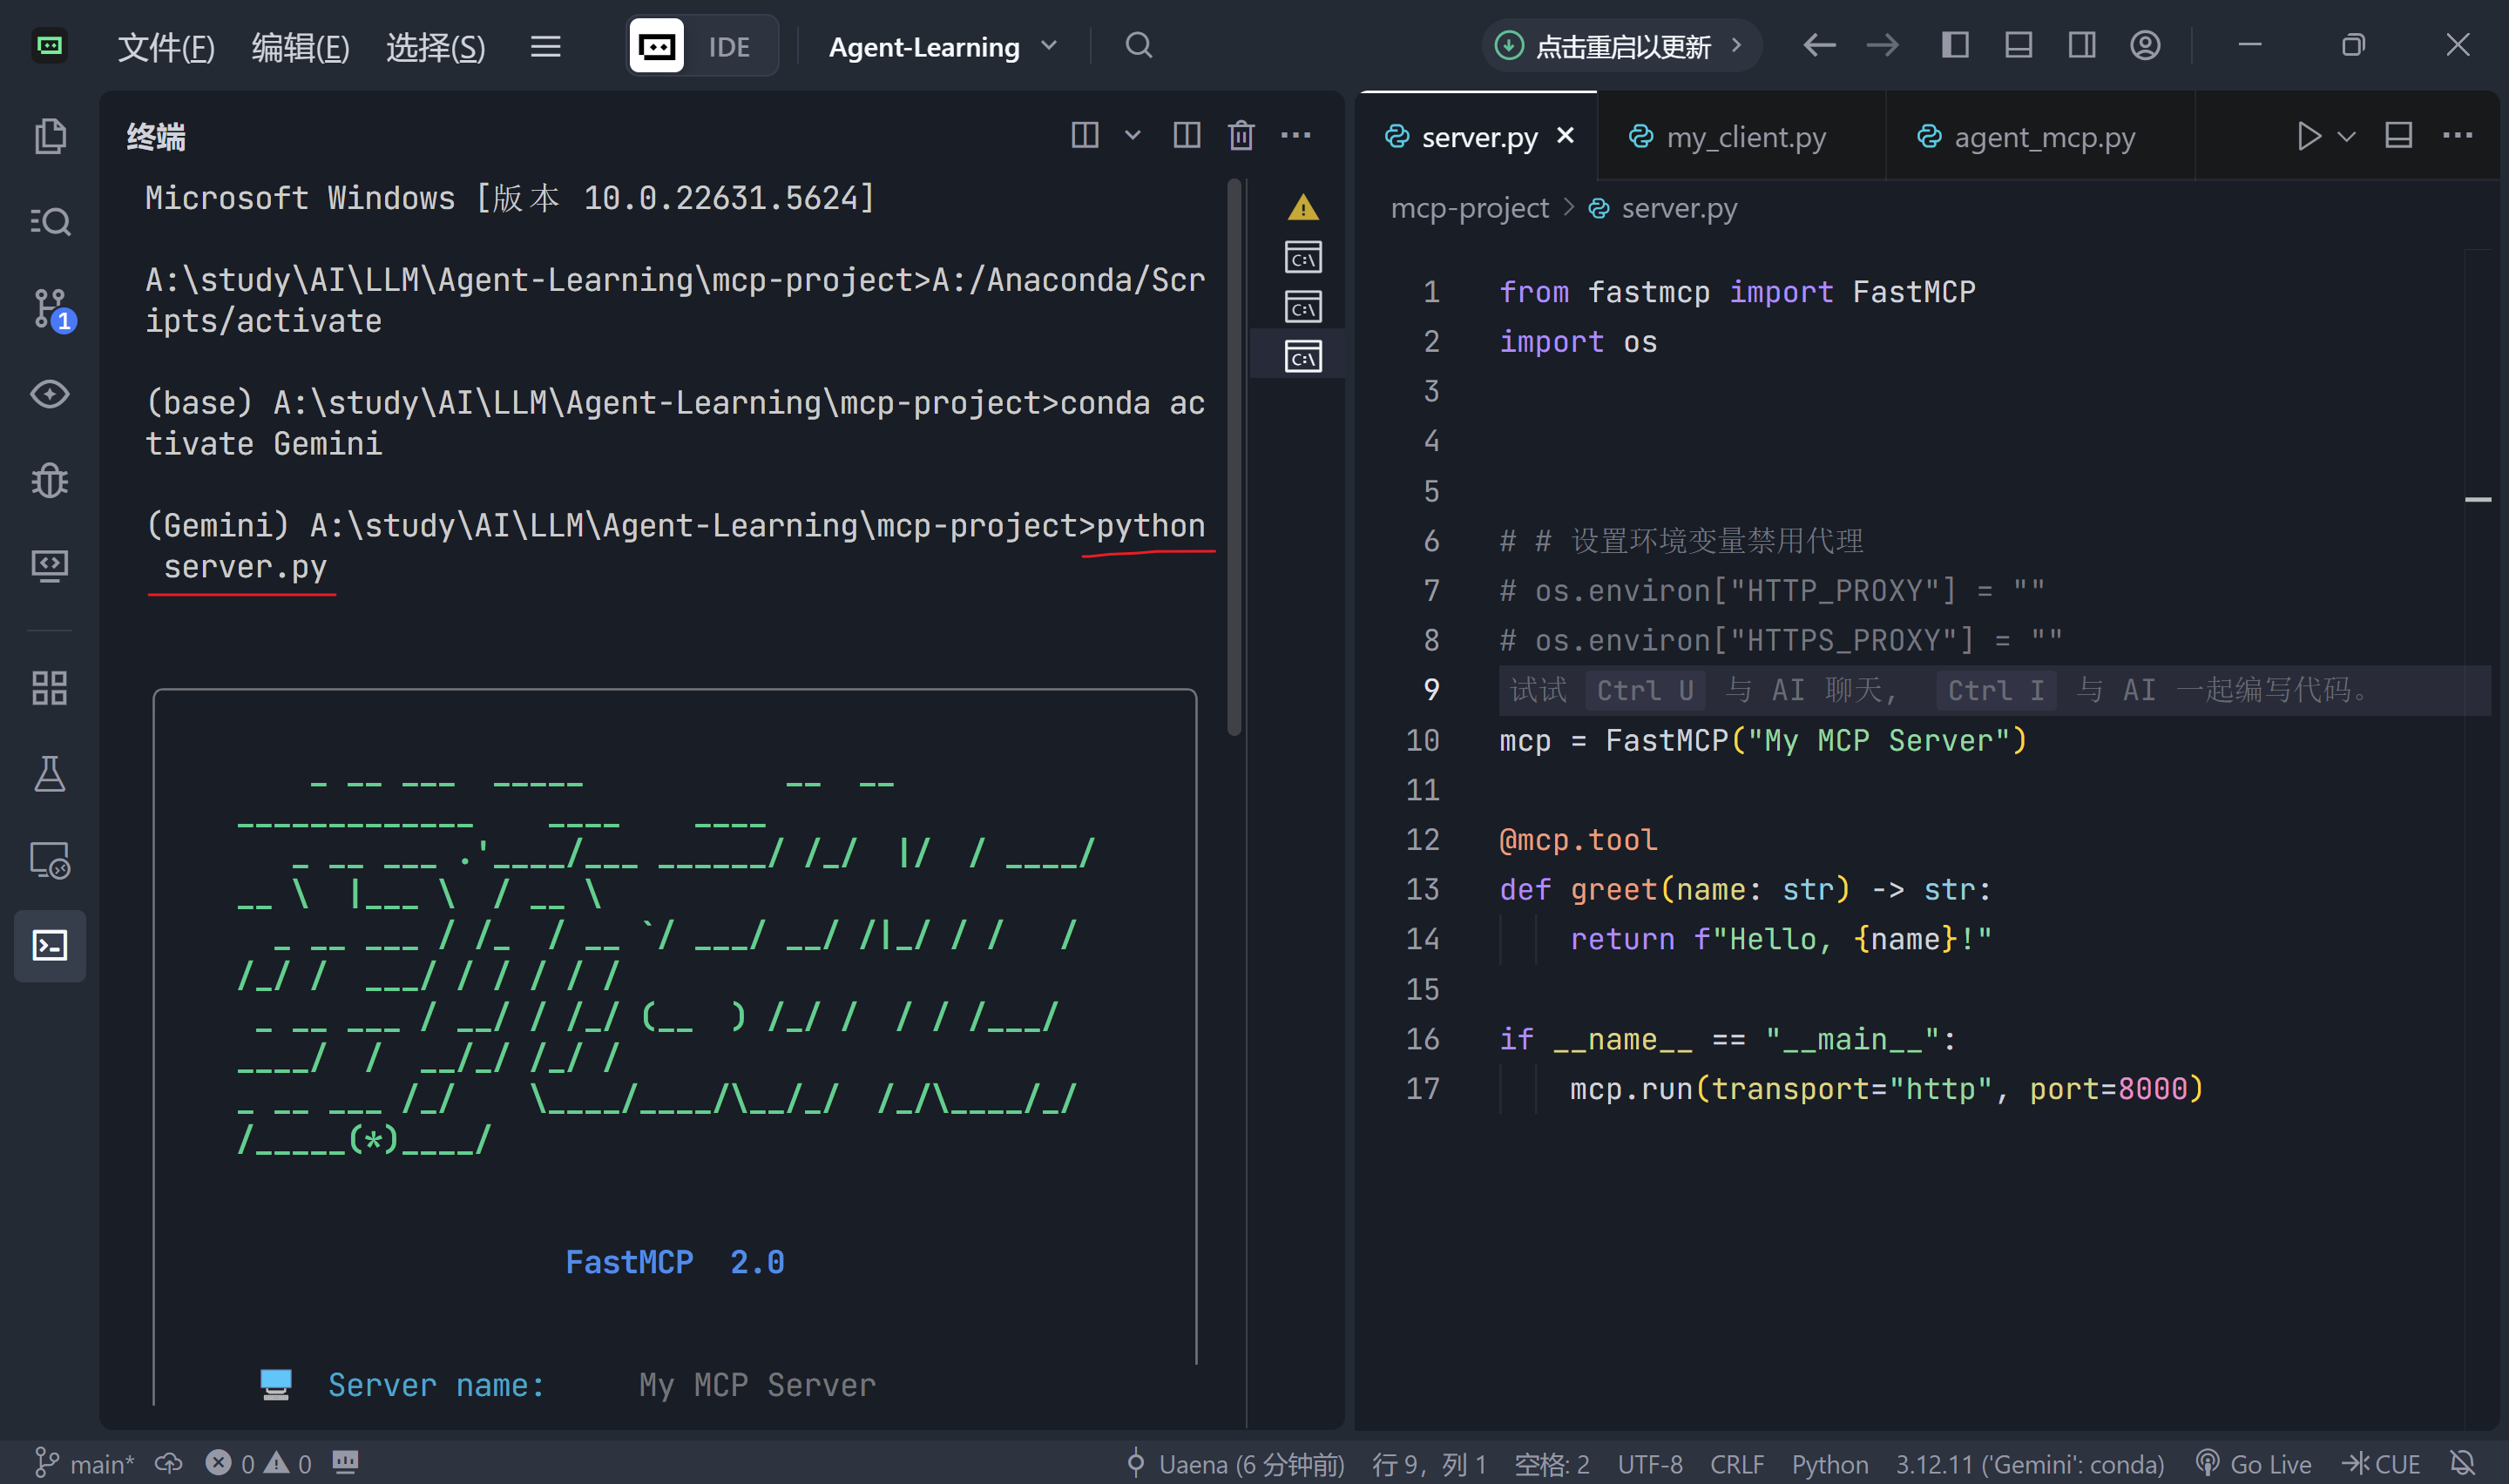

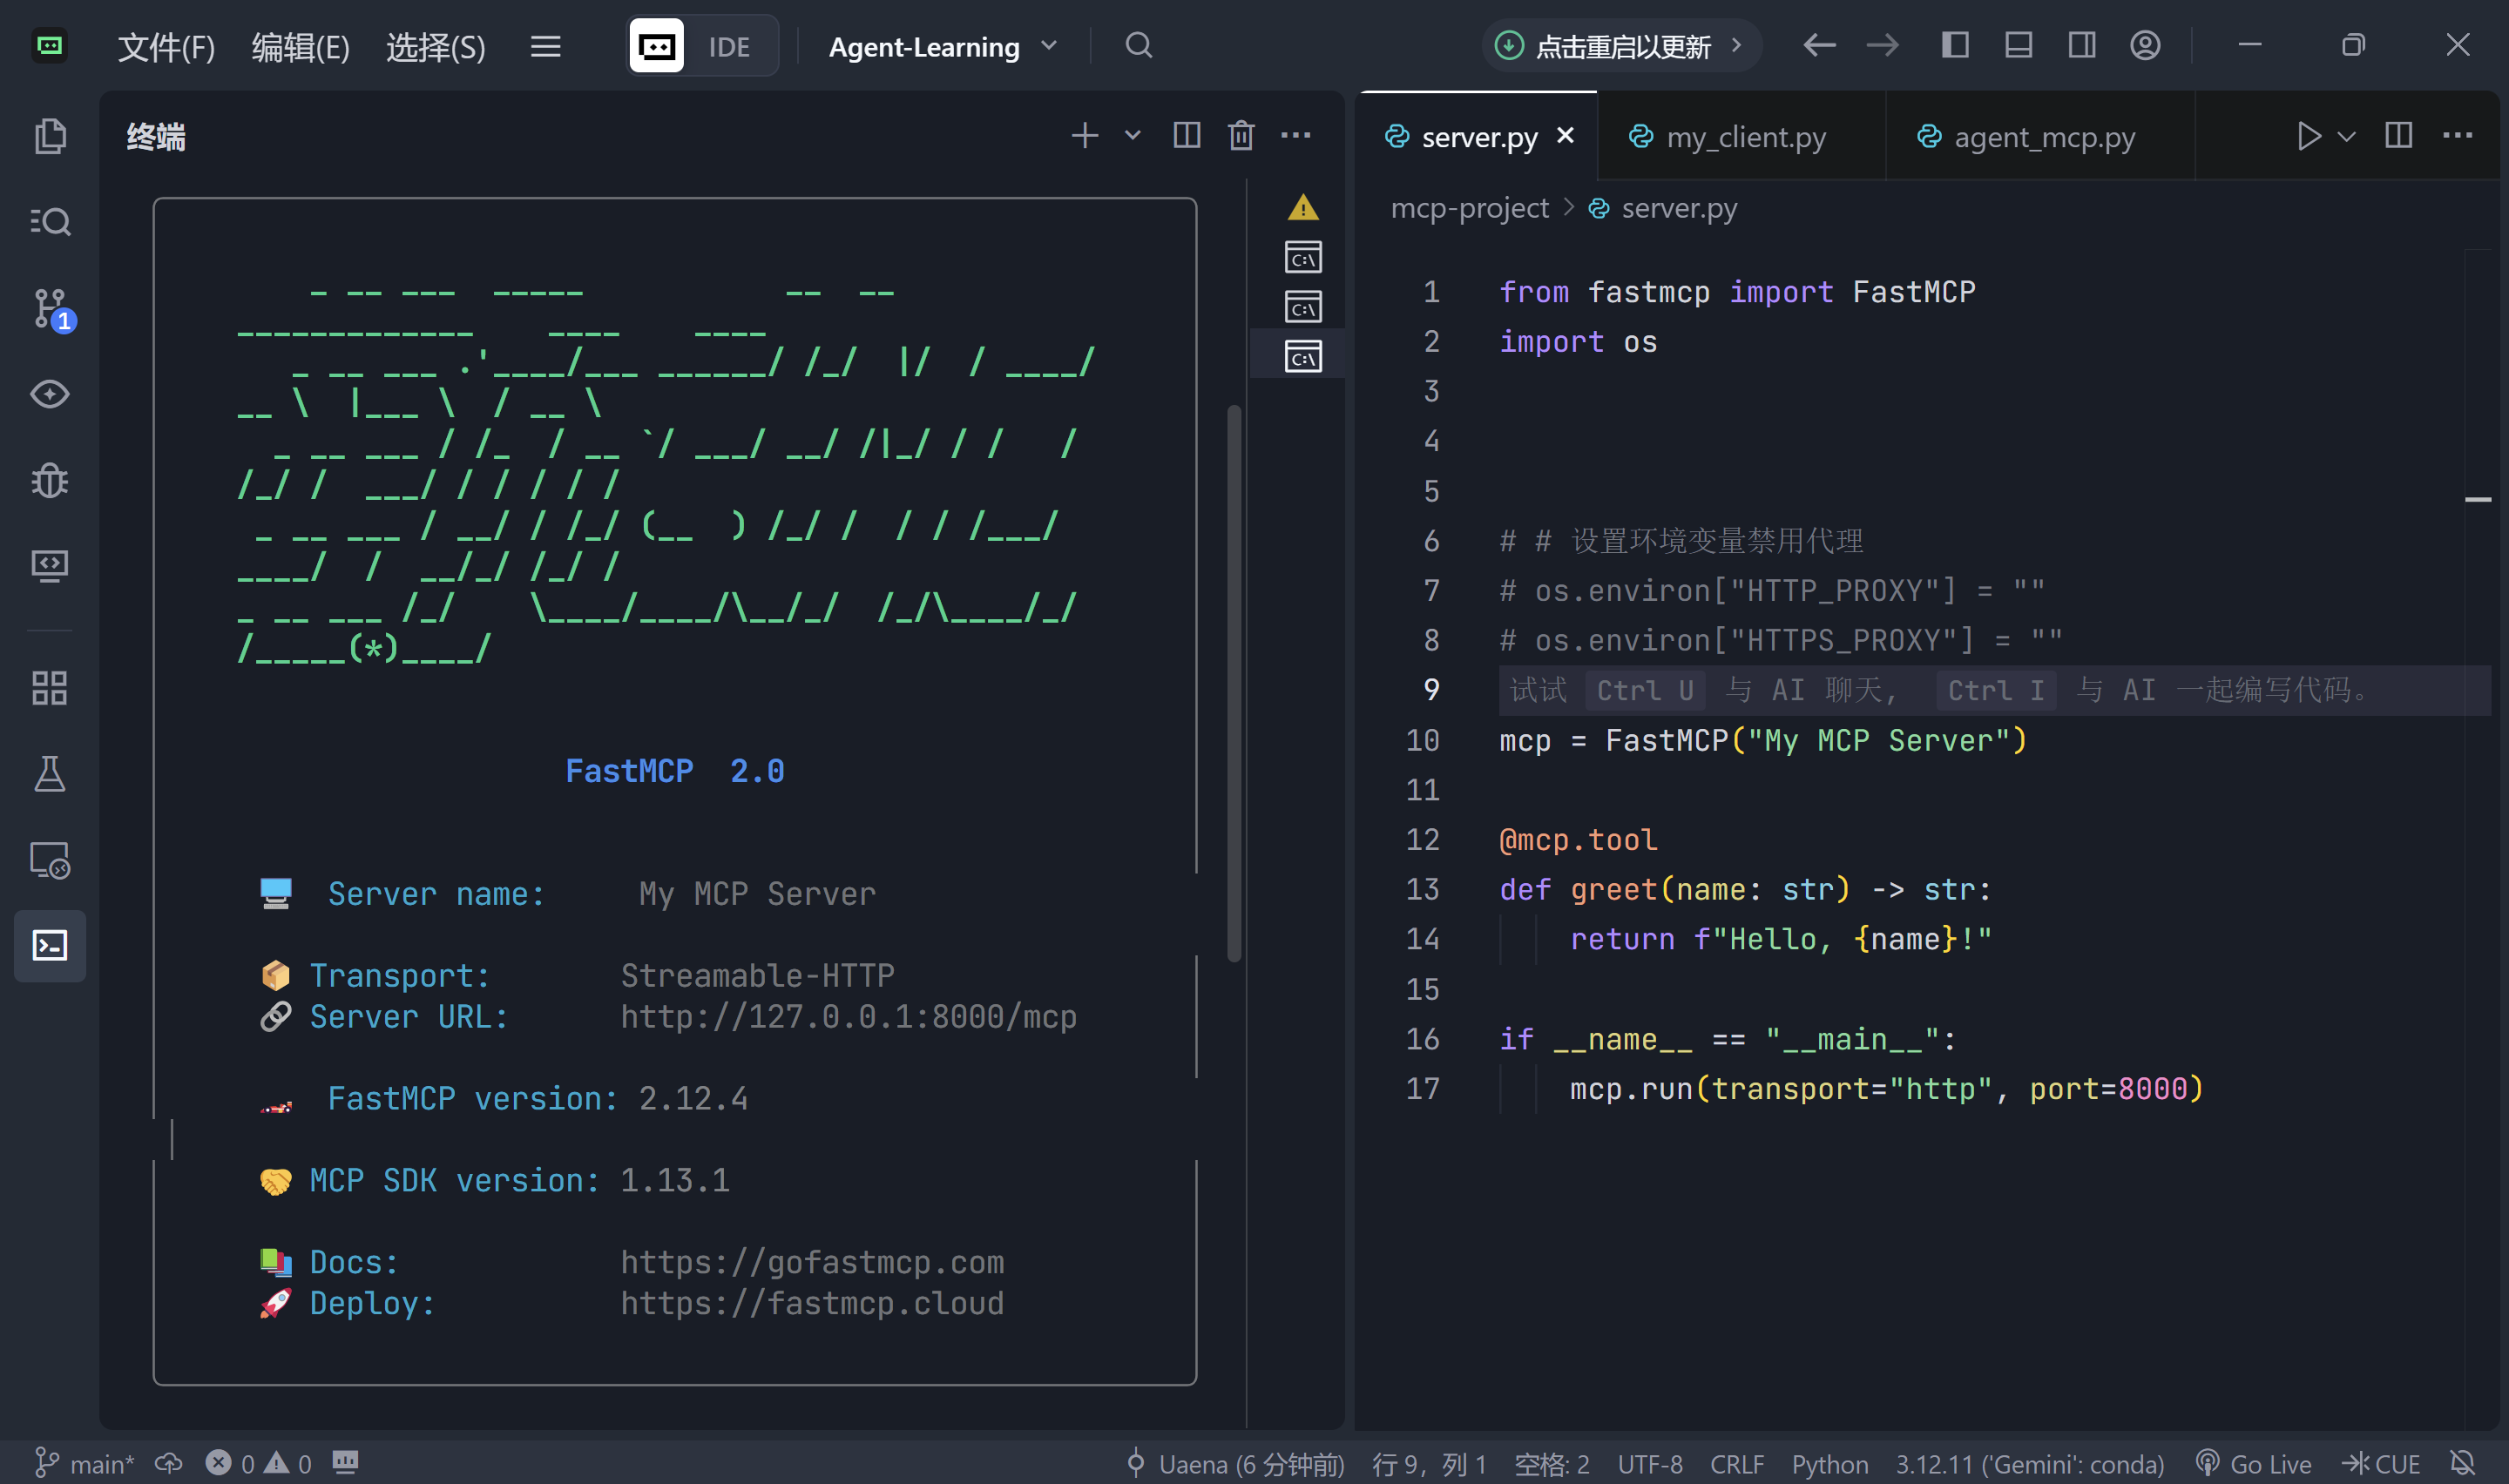

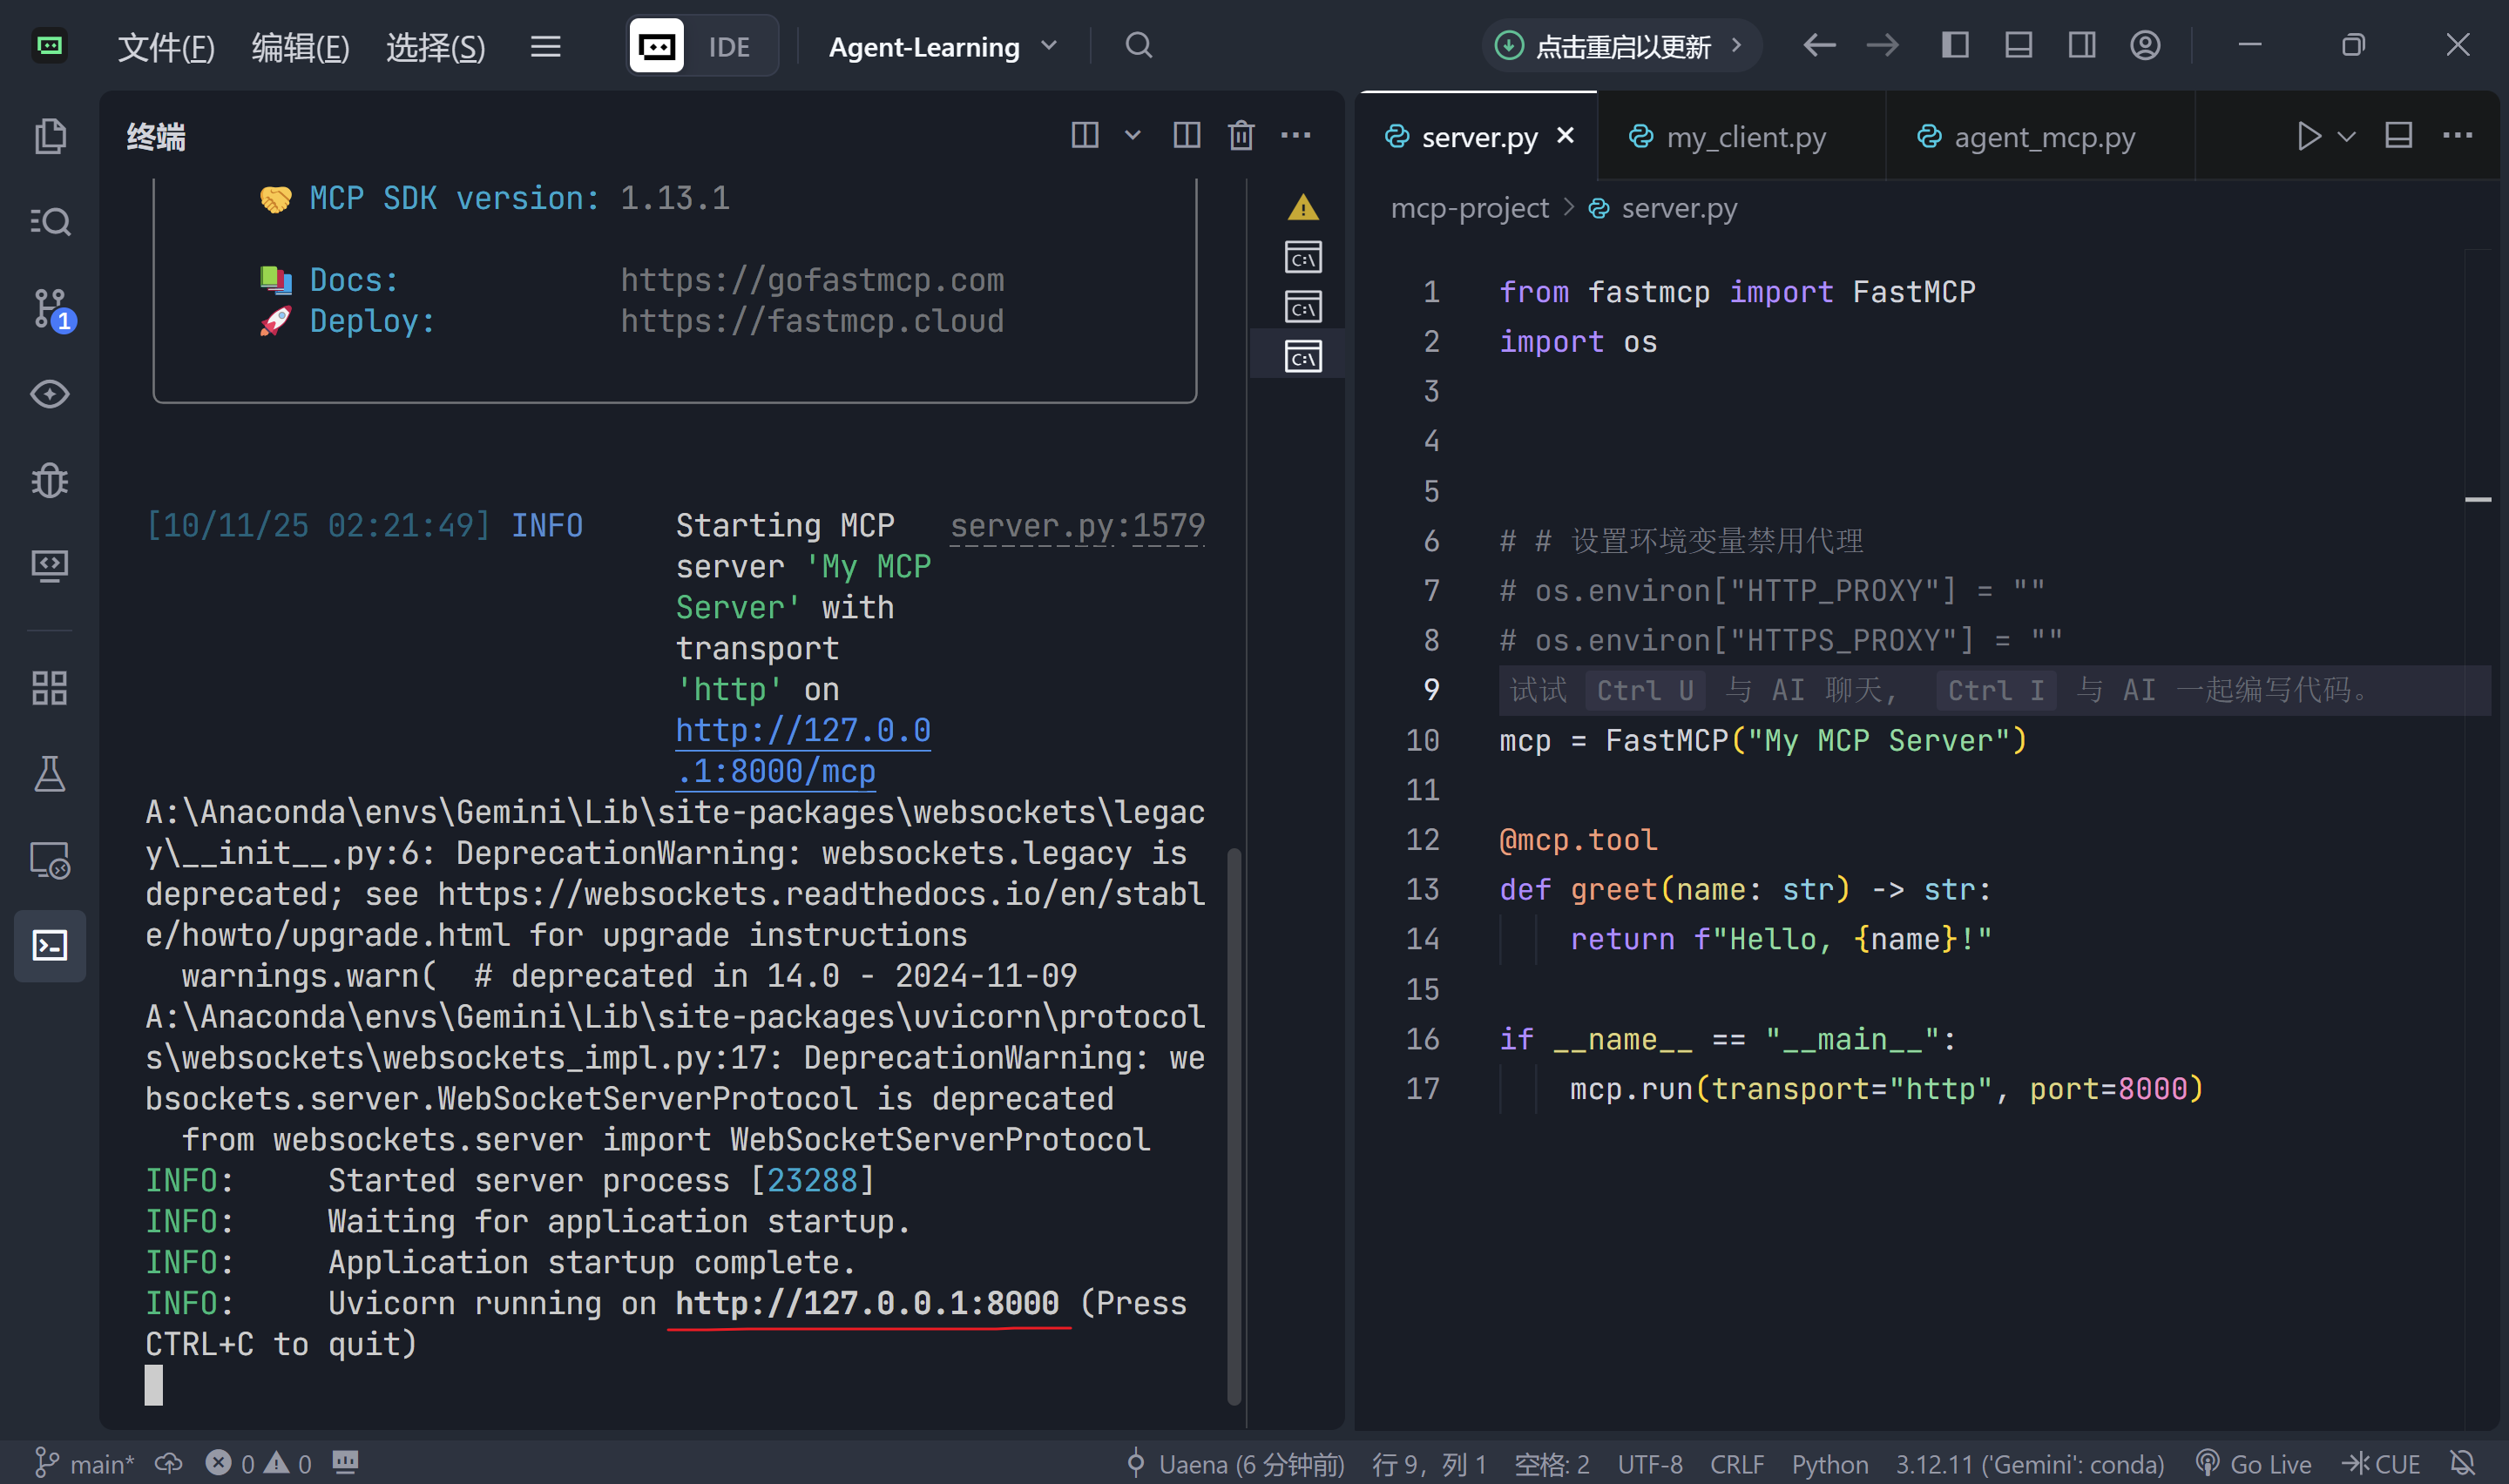


一旦您的服务器运行HTTP传输，您就可以使用FastMCP客户端或任何支持MCP协议的LLM客户端连接到它：
```python
import asyncio
from fastmcp import Client

client = Client("http://localhost:8000/mcp")

async def call_tool(name: str):
    async with client:
        result = await client.call_tool("greet", {"name": name})
        print(result)

asyncio.run(call_tool("Ford"))
```





使用代码连接MCP服务

In [ ]:
# mcp-project\my_client.py
import asyncio
import os
from fastmcp import Client

# 设置环境变量禁用代理
os.environ["HTTP_PROXY"] = ""
os.environ["HTTPS_PROXY"] = ""
os.environ["NO_PROXY"] = "localhost,127.0.0.1"  # 明确指定这些地址不使用代理


client = Client("http://localhost:8000/mcp")

async def call_tool(name: str):
    async with client:
        result = await client.call_tool("greet", {"name": name})
        print(result)

asyncio.run(call_tool("Ford"))



asyncio.run(call_tool("Asuka"))

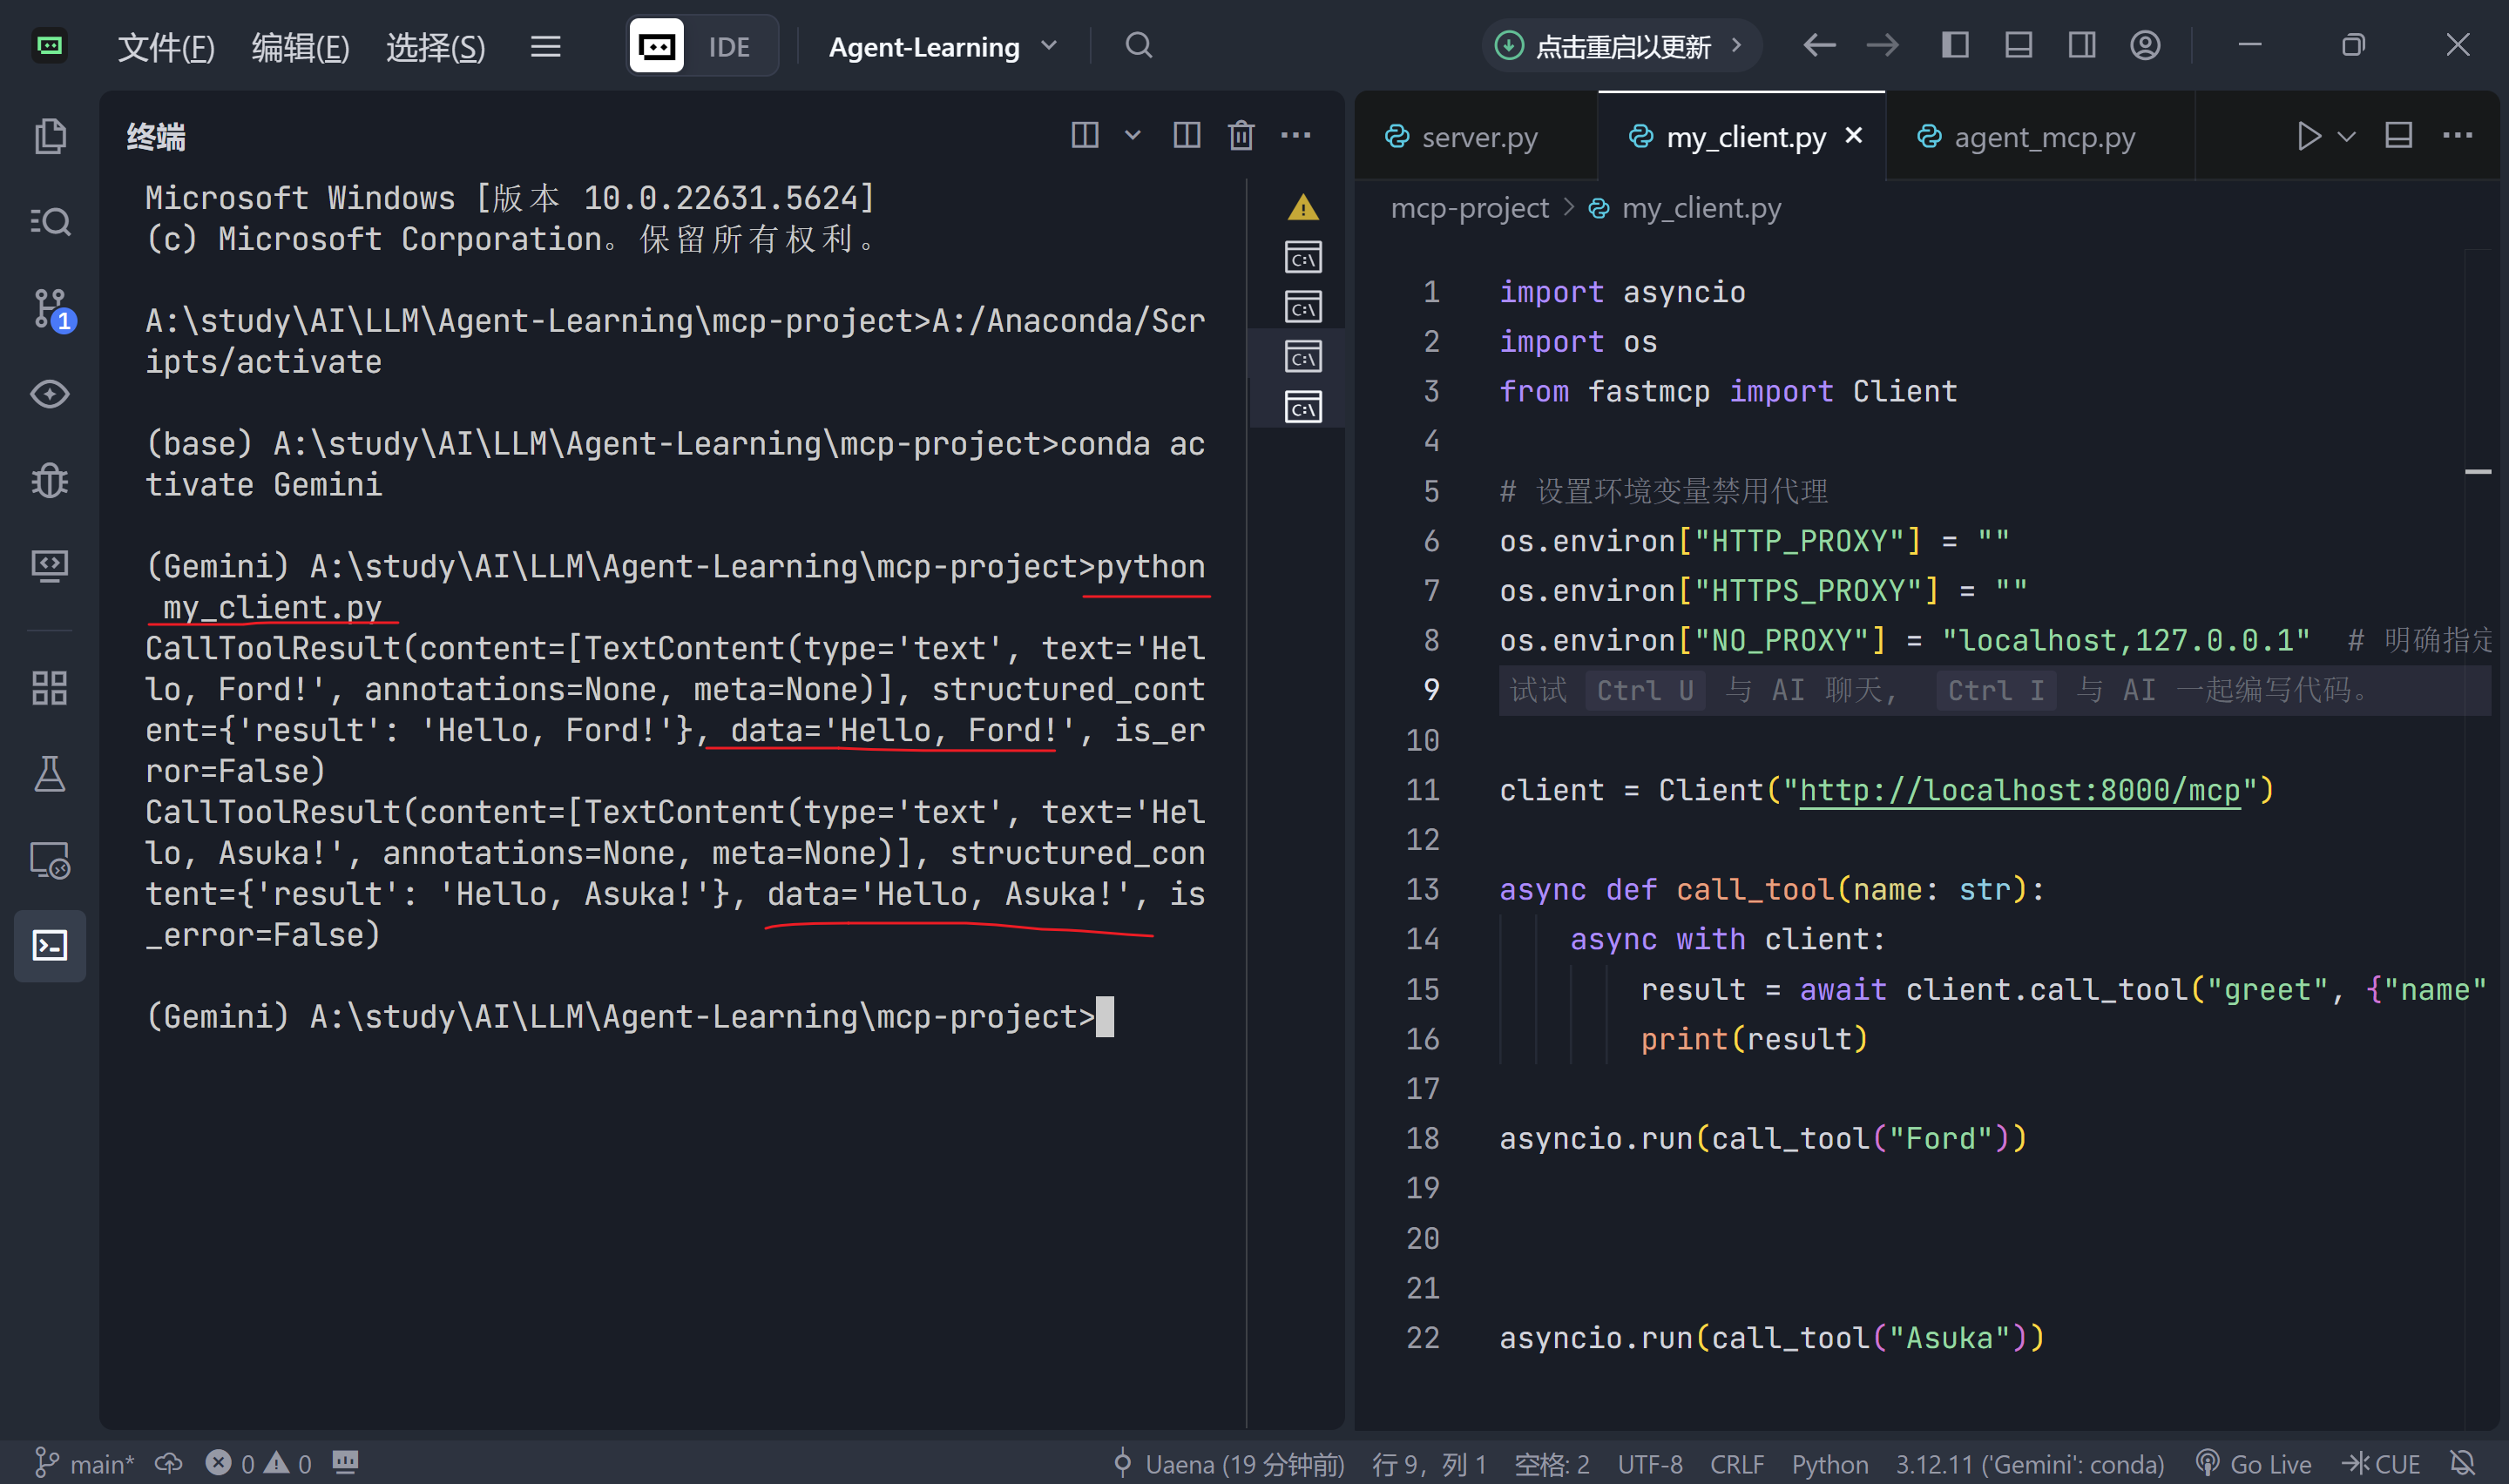

在DeepChat中配置该MCP服务。

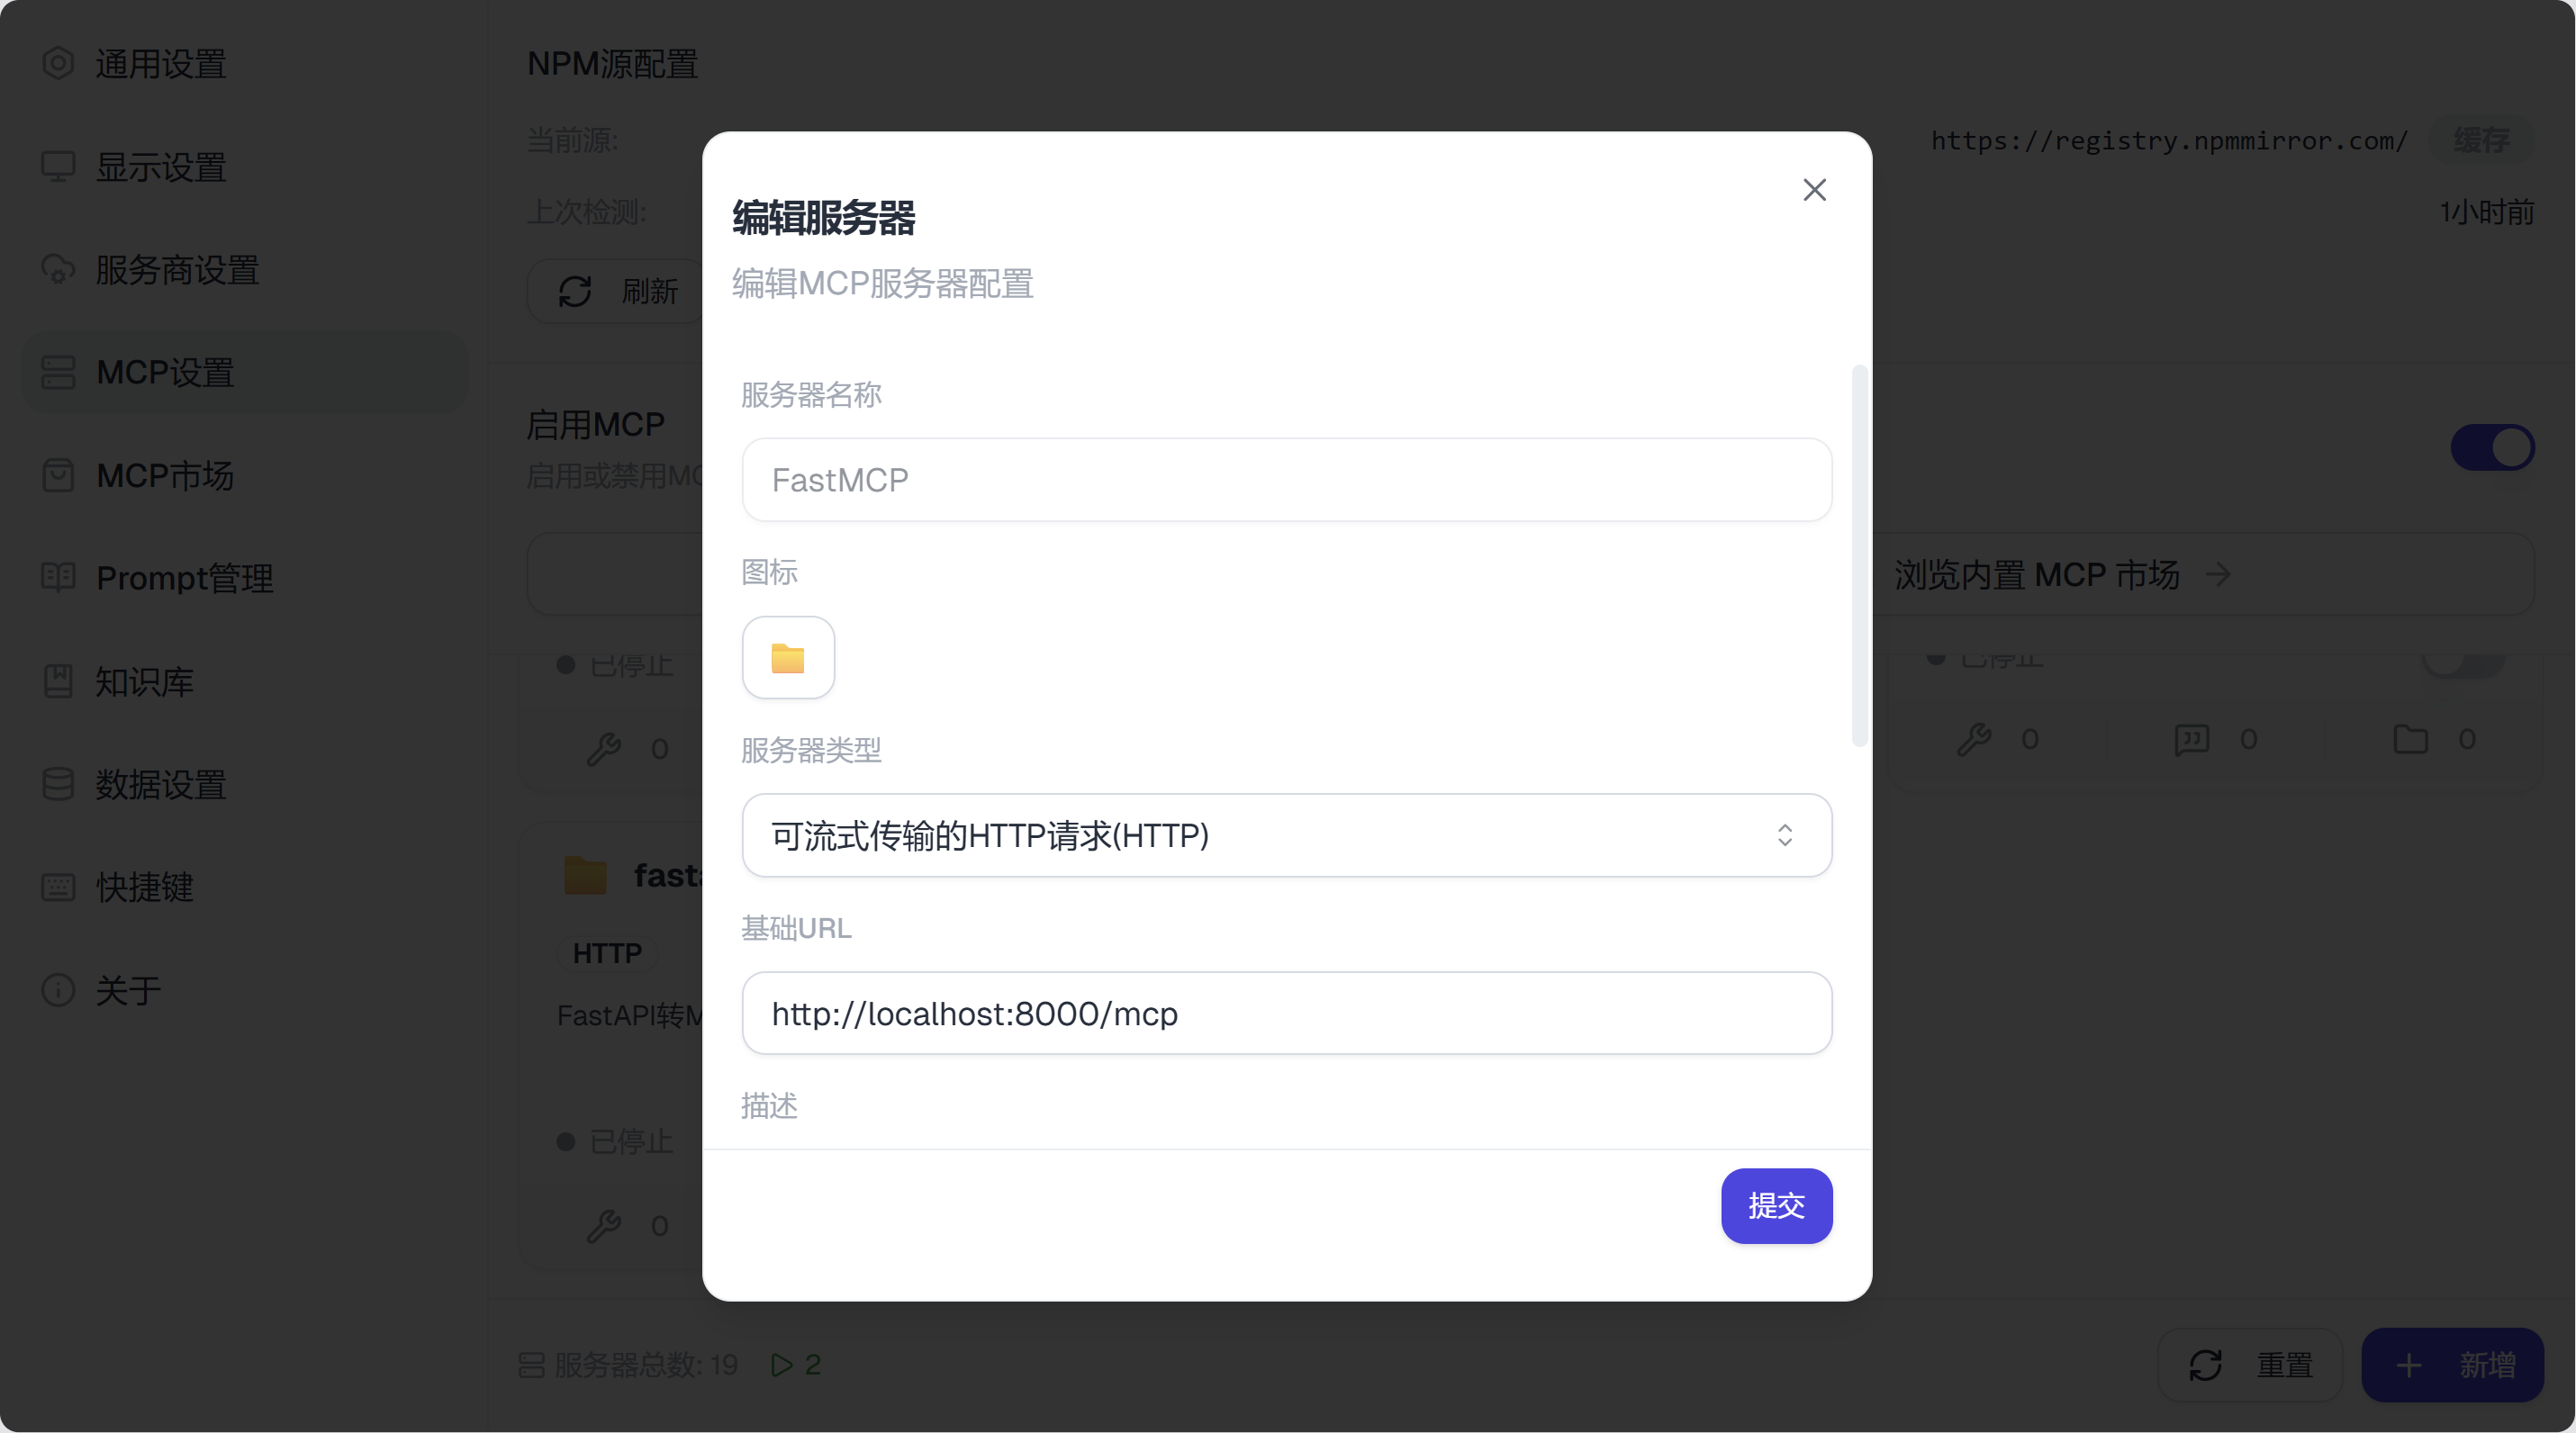

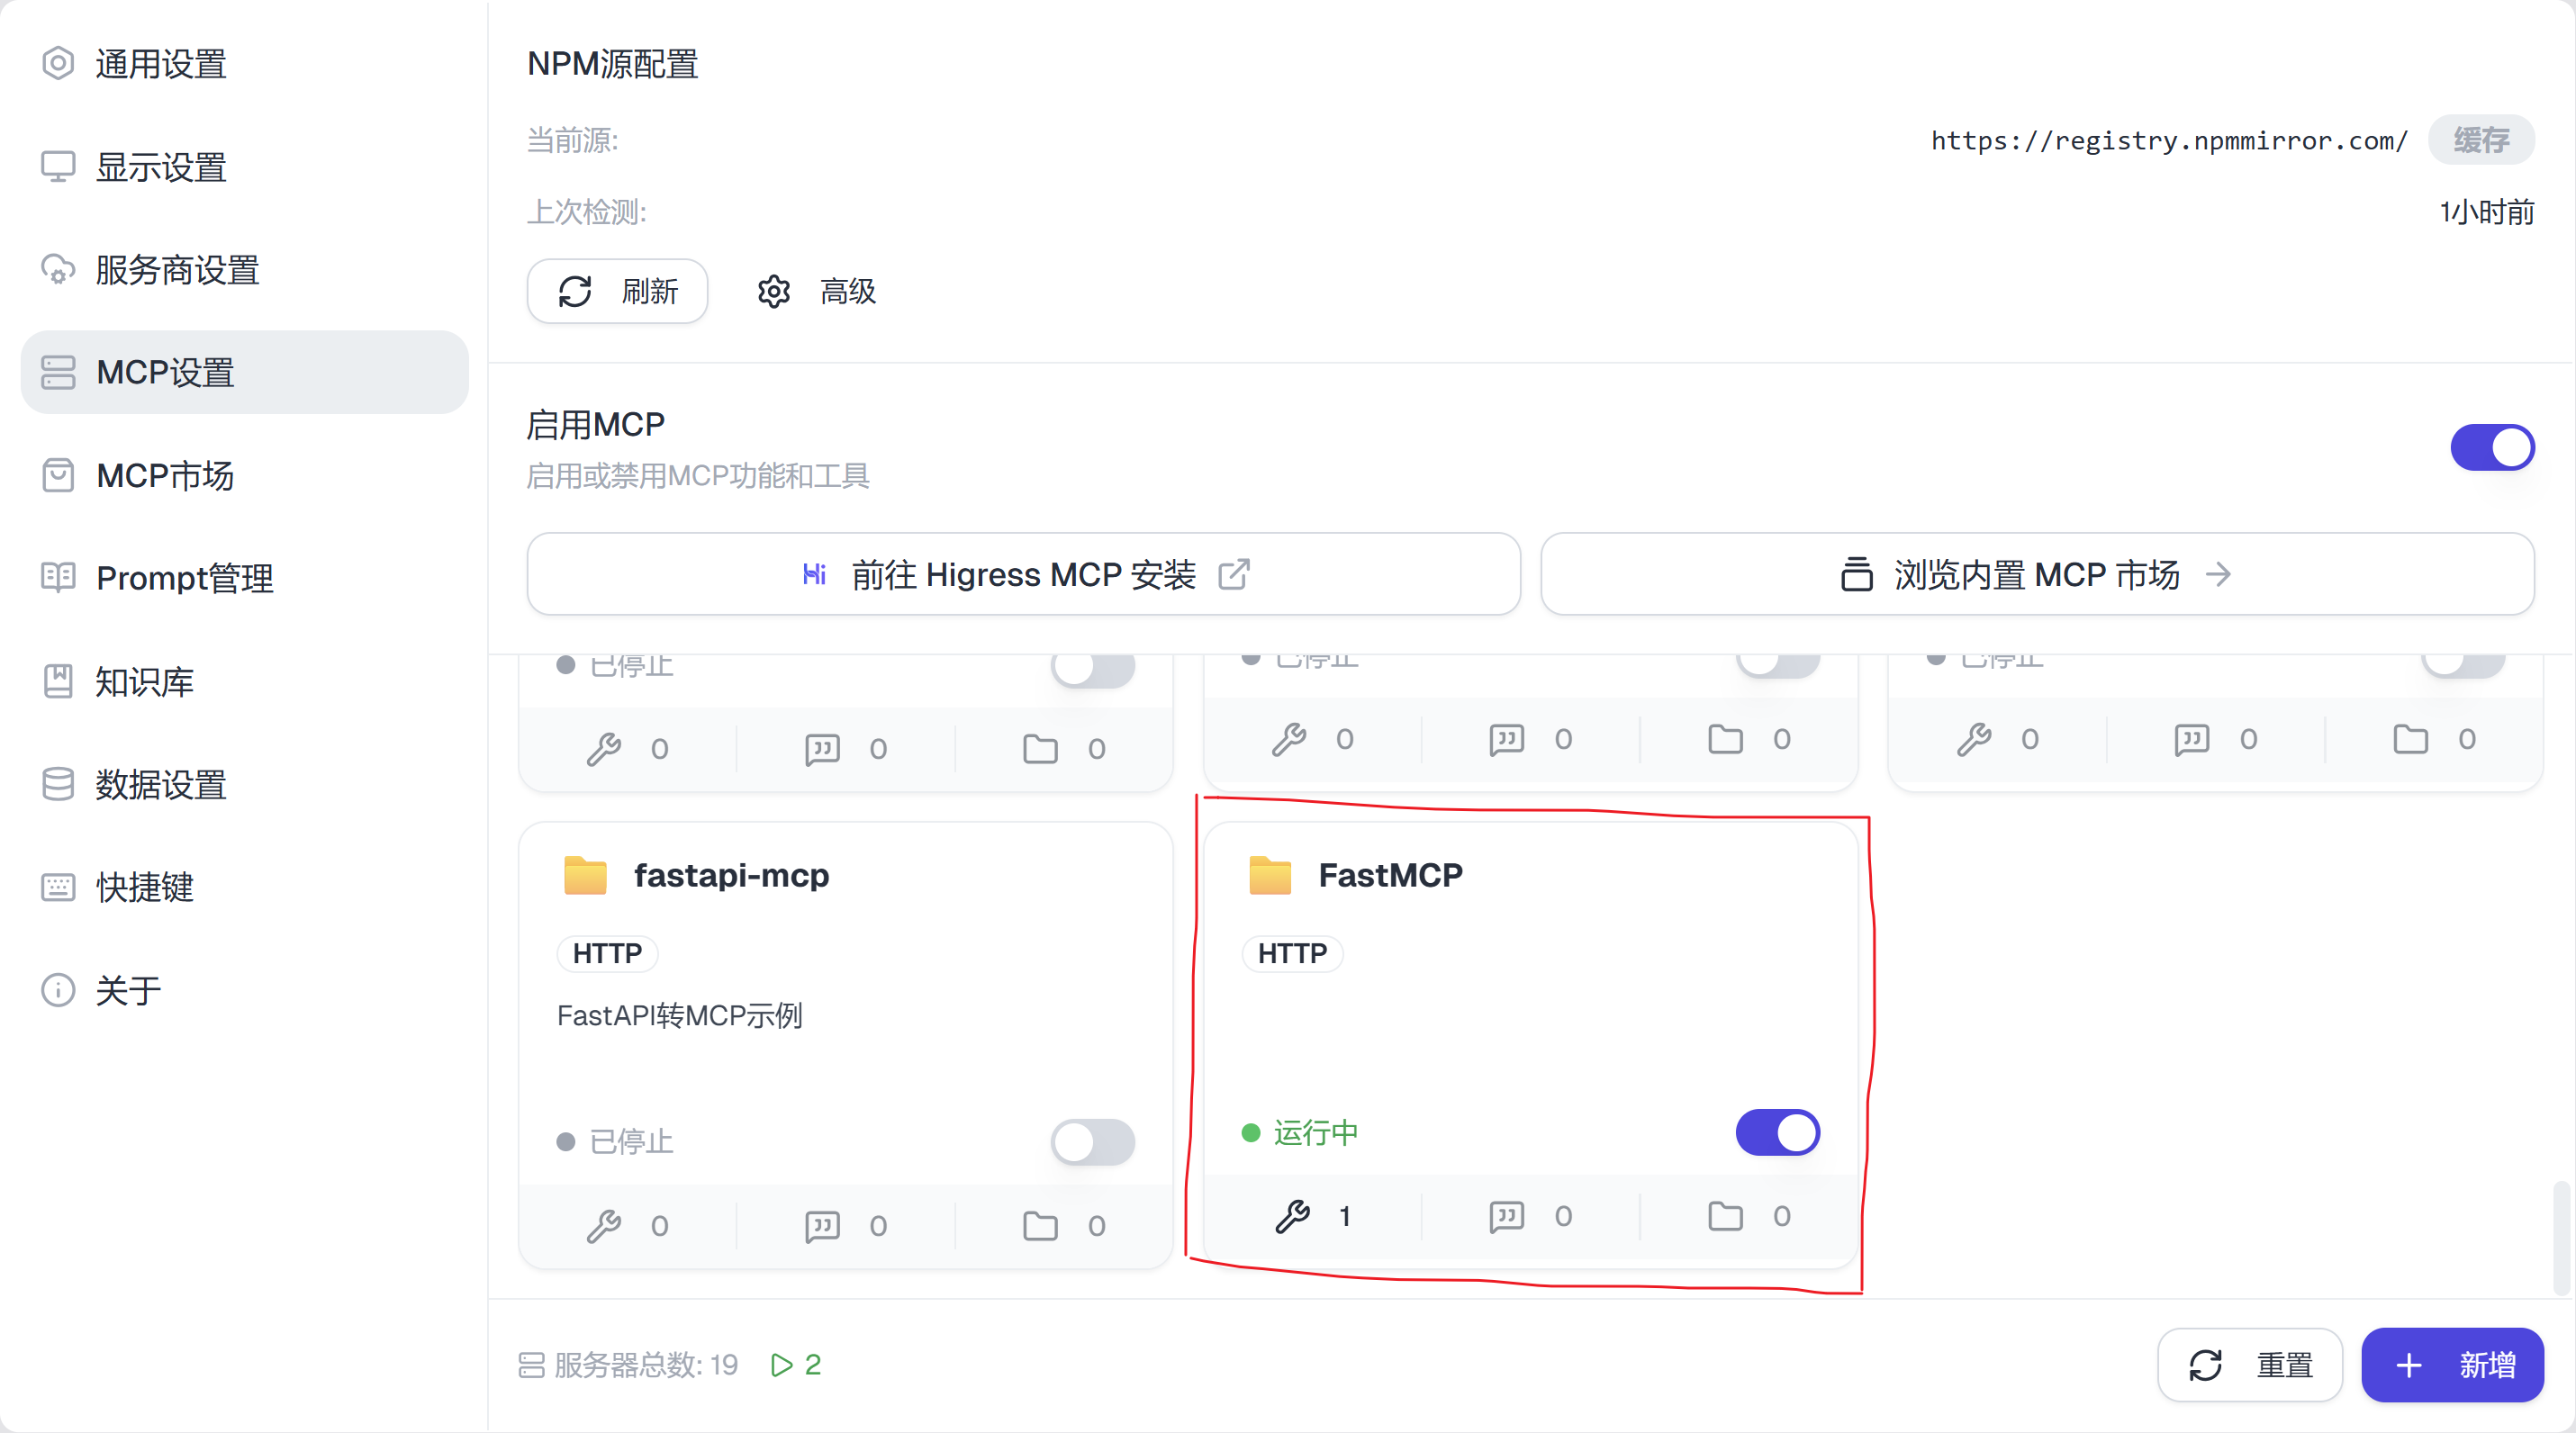

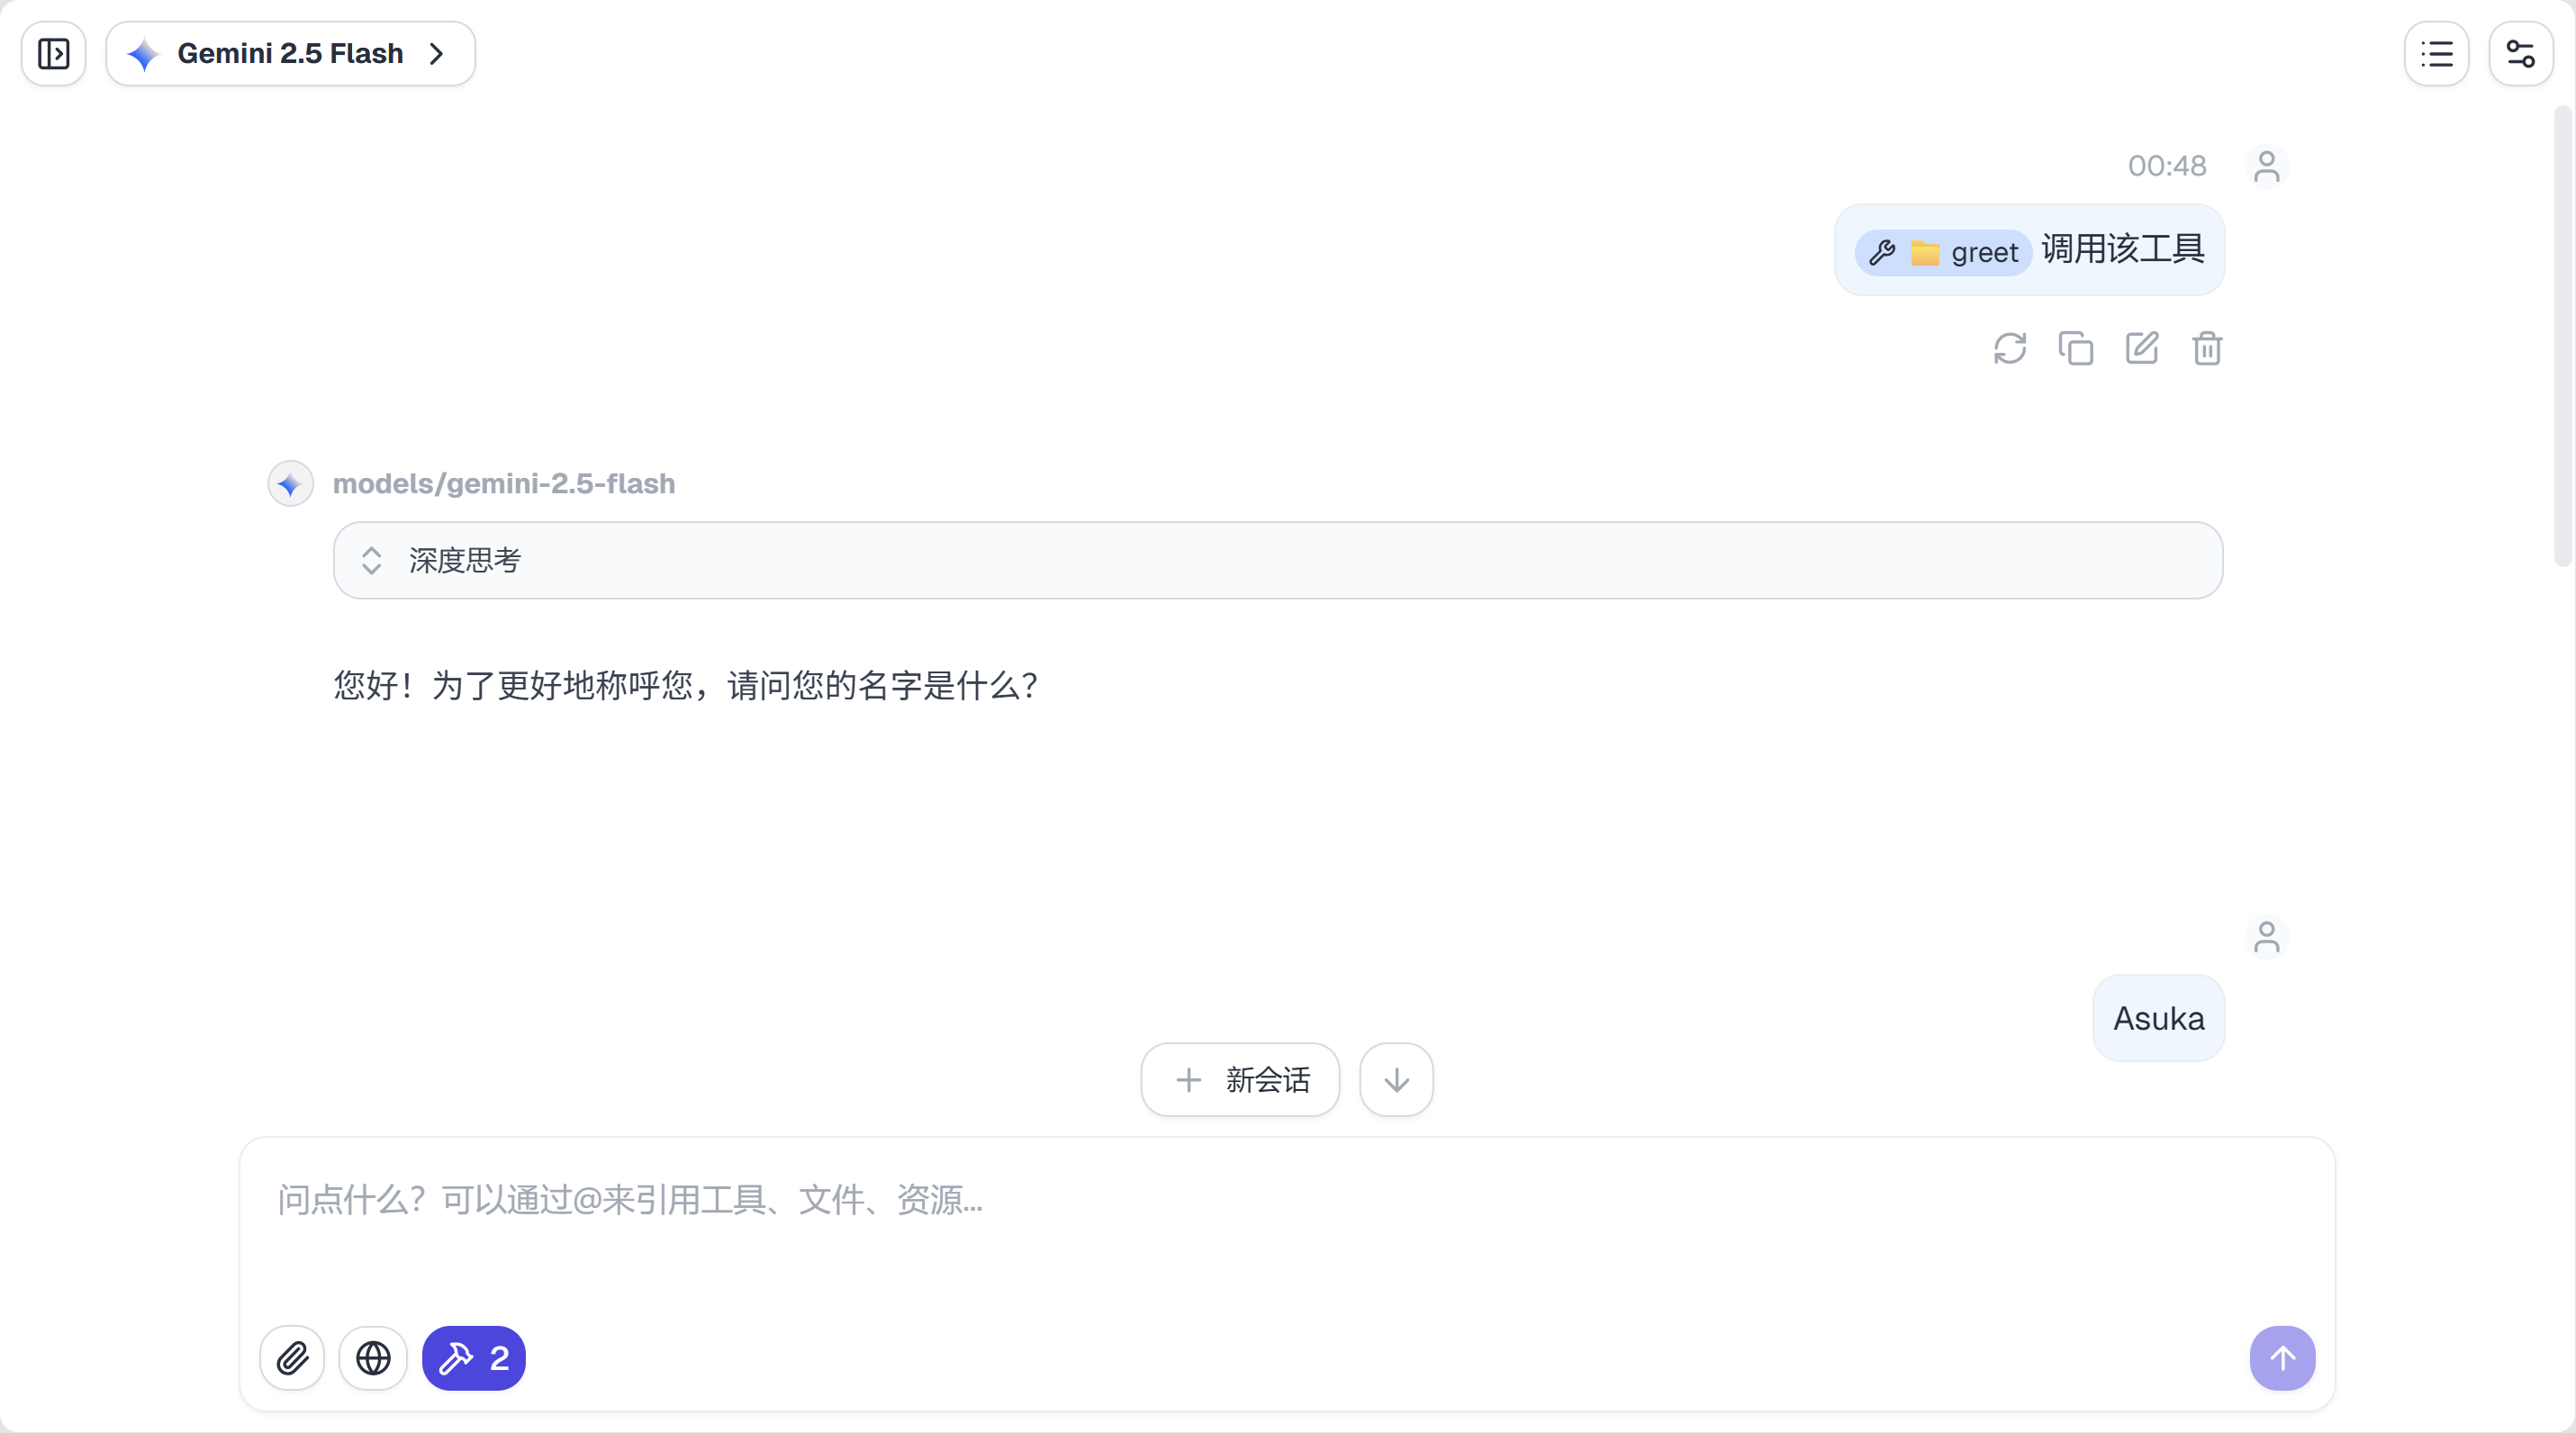

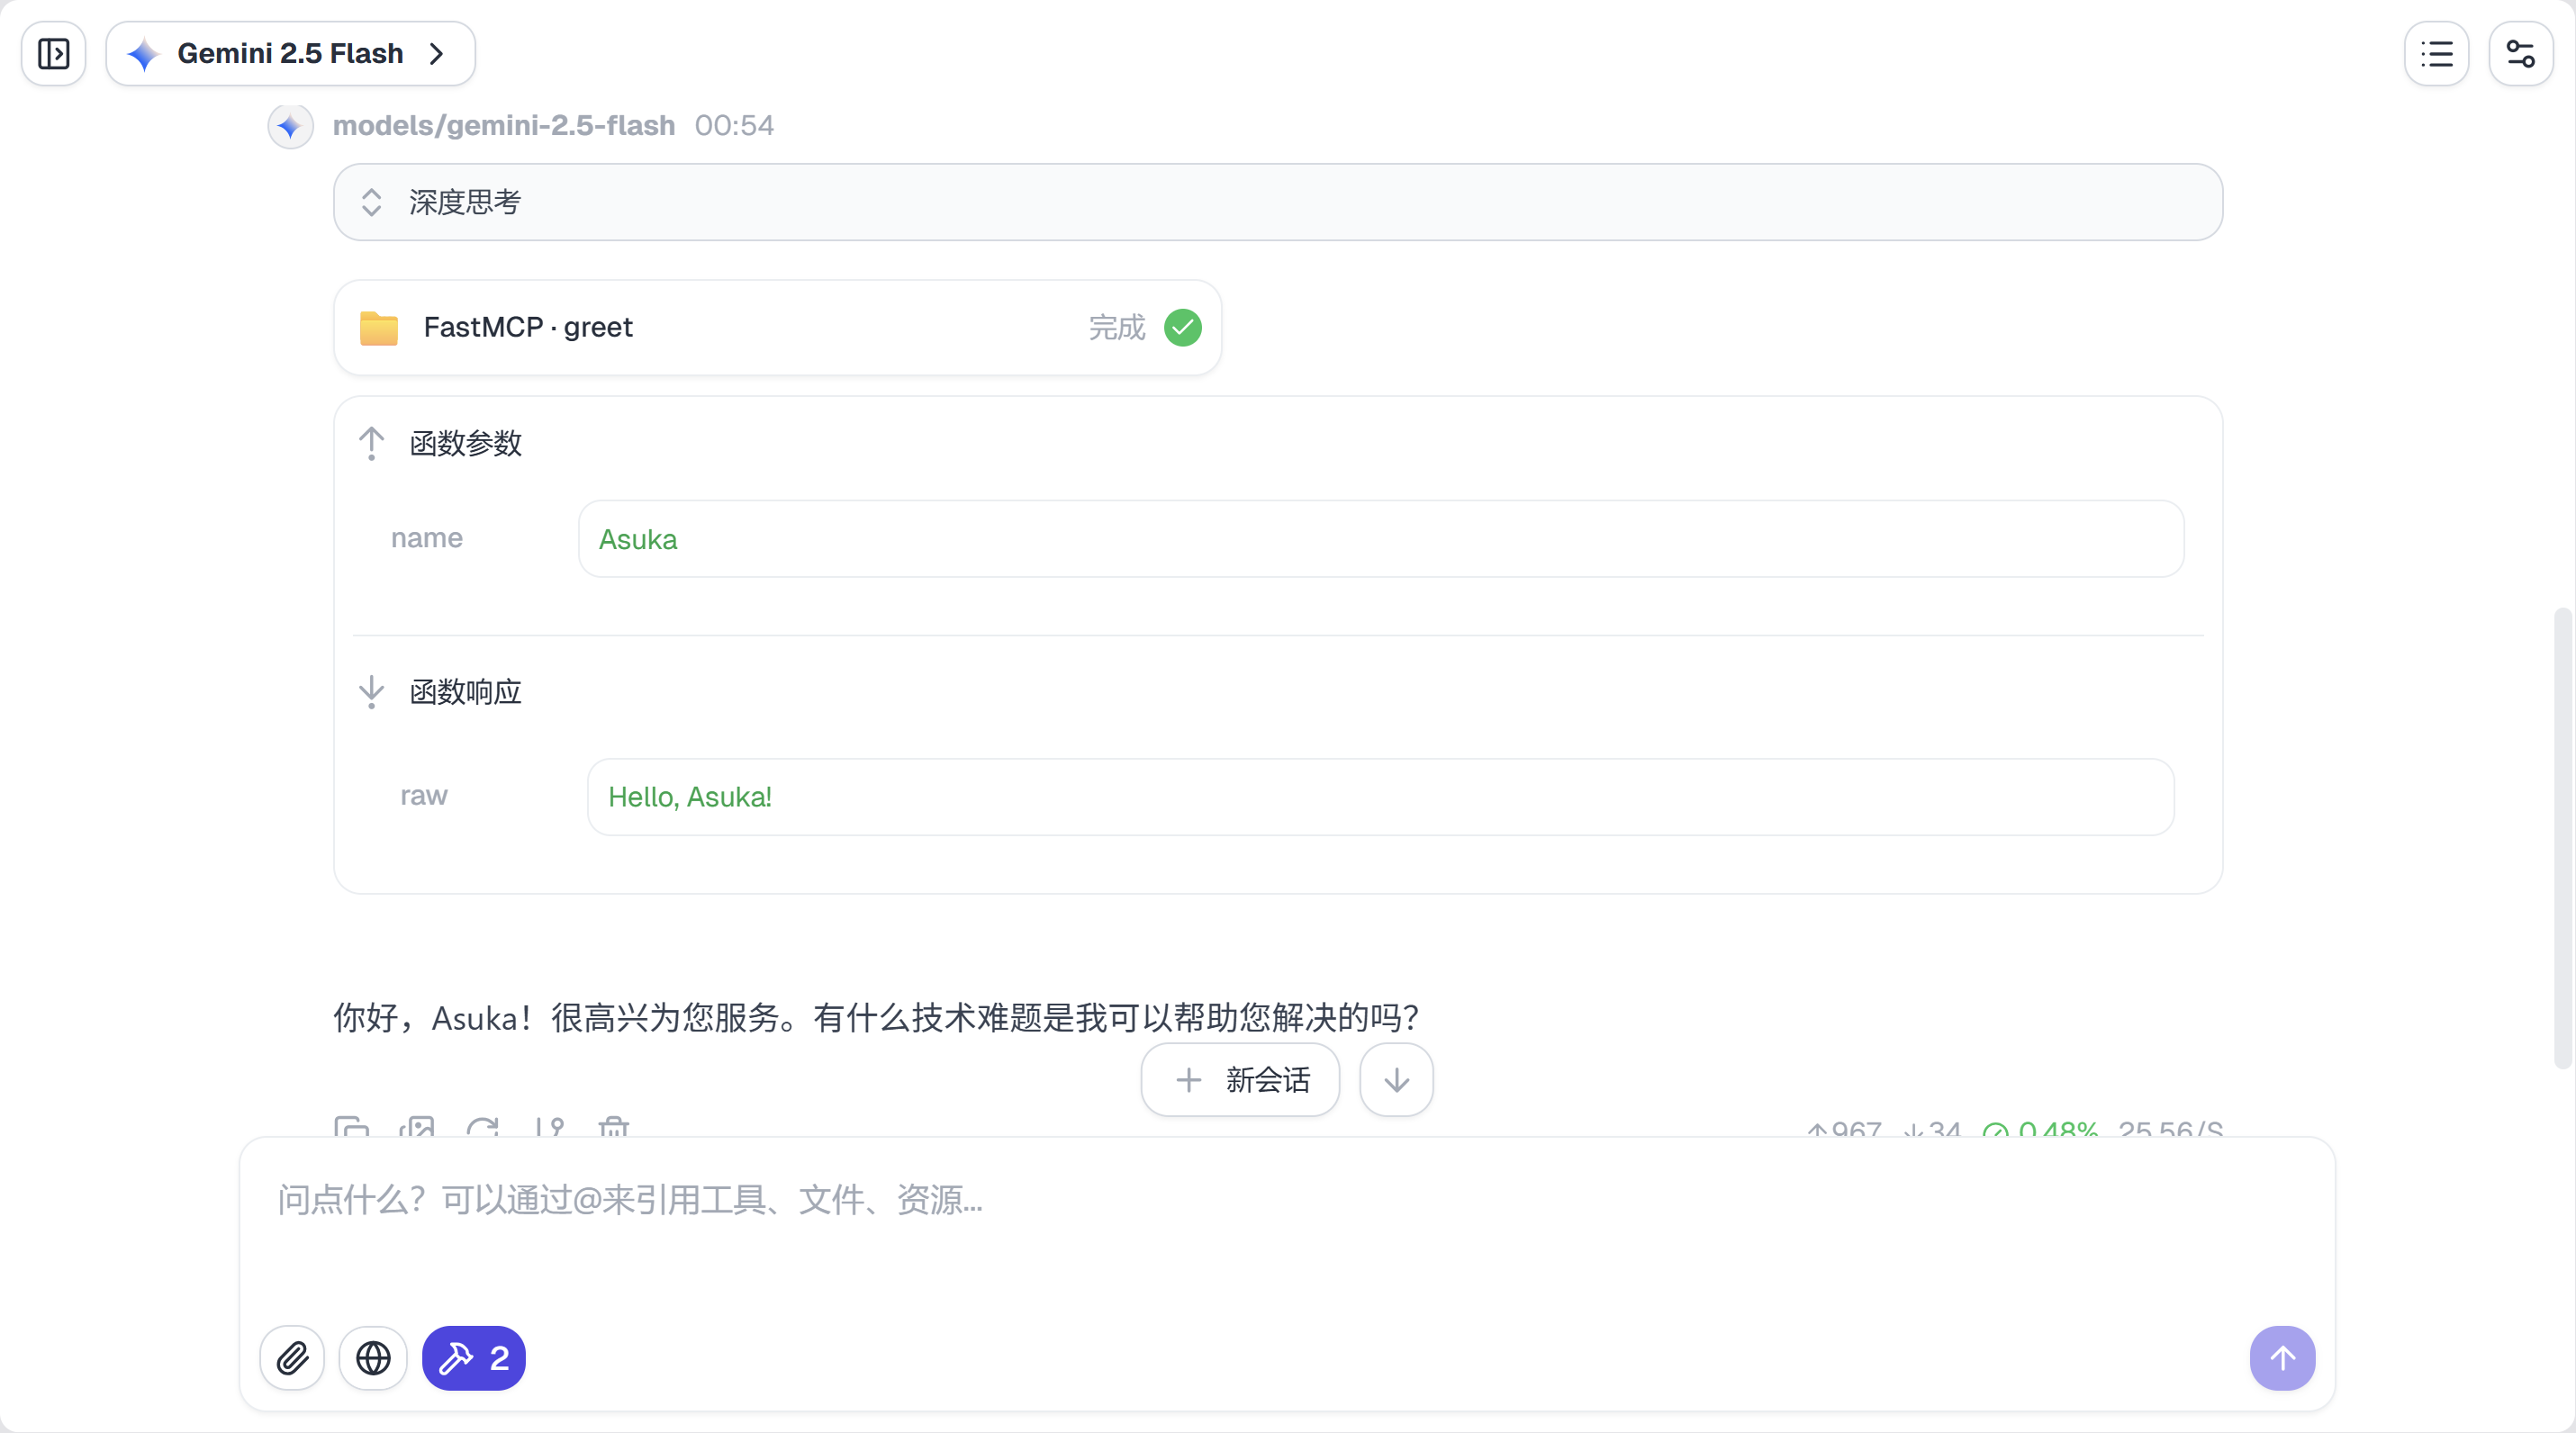

https://langchain-ai.github.io/langgraph/agents/mcp/

LangGraph代理可以通过langchain-mcp-adapters库使用MCP服务器上定义的工具。

安装langchain-mcp-adapters库以在LangGraph中使用MCP工具：

```powershell
pip install langchain-mcp-adapters
```


Agent using tools defined on MCP servers示例代码如下：
```python
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent

client = MultiServerMCPClient(
    {
        "math": {
            "command": "python",
            # Replace with absolute path to your math_server.py file
            "args": ["/path/to/math_server.py"],
            "transport": "stdio",
        },
        "weather": {
            # Ensure you start your weather server on port 8000
            "url": "http://localhost:8000/mcp",
            "transport": "streamable_http",
        }
    }
)
tools = await client.get_tools()
agent = create_react_agent(
    "anthropic:claude-3-7-sonnet-latest",
    tools
)
math_response = await agent.ainvoke(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 12?"}]}
)
weather_response = await agent.ainvoke(
    {"messages": [{"role": "user", "content": "what is the weather in nyc?"}]}
)
```

Workflow using MCP tools with ToolNode示例代码如下：
```python
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode

# Initialize the model
model = init_chat_model("anthropic:claude-3-5-sonnet-latest")

# Set up MCP client
client = MultiServerMCPClient(
    {
        "math": {
            "command": "python",
            # Make sure to update to the full absolute path to your math_server.py file
            "args": ["./examples/math_server.py"],
            "transport": "stdio",
        },
        "weather": {
            # make sure you start your weather server on port 8000
            "url": "http://localhost:8000/mcp/",
            "transport": "streamable_http",
        }
    }
)
tools = await client.get_tools()

# Bind tools to model
model_with_tools = model.bind_tools(tools)

# Create ToolNode
tool_node = ToolNode(tools)

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

# Define call_model function
async def call_model(state: MessagesState):
    messages = state["messages"]
    response = await model_with_tools.ainvoke(messages)
    return {"messages": [response]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model",
    should_continue,
)
builder.add_edge("tools", "call_model")

# Compile the graph
graph = builder.compile()

# Test the graph
math_response = await graph.ainvoke(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 12?"}]}
)
weather_response = await graph.ainvoke(
    {"messages": [{"role": "user", "content": "what is the weather in nyc?"}]}
)
```



In [ ]:
# mcp-project\agent_mcp.py
# --- 第一步：安装和导入 ---
# 确保所有库都是最新版本
# !pip install -U langchain langchain_google_genai fastmcp langchain_mcp_adapters langgraph

import os
import getpass
import asyncio
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage, HumanMessage
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent

# --- 第二步：配置环境 ---
if 'GOOGLE_API_KEY' not in os.environ:
    os.environ['GOOGLE_API_KEY'] = getpass.getpass('Enter your Google API Key: ')



# --- 第三步：初始化大脑、工具和 Prompt ---
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)


# 设置环境变量禁用代理
# os.environ["HTTP_PROXY"] = ""
# os.environ["HTTPS_PROXY"] = ""
os.environ["NO_PROXY"] = "localhost,127.0.0.1"

# 创建 MCP 客户端
async def setup_agent():
    # 使用 MultiServerMCPClient 连接到 MCP 服务器
    client = MultiServerMCPClient(
        {
            "greet_service": {
                "url": "http://localhost:8000/mcp",
                "transport": "streamable_http",
            }
        }
    )

    # 获取 MCP 工具
    tools = await client.get_tools()

    # 使用 create_react_agent 创建 agent
    agent = create_react_agent(
        llm,
        tools
    )



    return agent

# --- 第四步：运行 Agent ---
async def main():
    agent = await setup_agent()

    # 初始化对话历史
    chat_history = []

    # 第一个问题
    question1 = "调用greet工具向张三问好"

    # 调用 agent
    response1 = await agent.ainvoke({
        "messages": [
          {
            "role": "user",
            "content": question1
          }
        ]
    })

    # 打印出 Agent 的回答
    print("\nUser Question 1:", question1)

    # 从响应中提取最后一条消息的内容
    if "messages" in response1:
        last_message = response1["messages"][-1]
        agent_answer = last_message.content
        print("Agent Answer 1:", agent_answer)
    else:
        print("Agent Answer 1:", response1)  # 打印整个响应以便调试

    # 更新对话历史
    chat_history.extend([
        HumanMessage(content=question1),
        last_message  # 直接添加 AIMessage 对象
    ])

if __name__ == "__main__":
    asyncio.run(main())


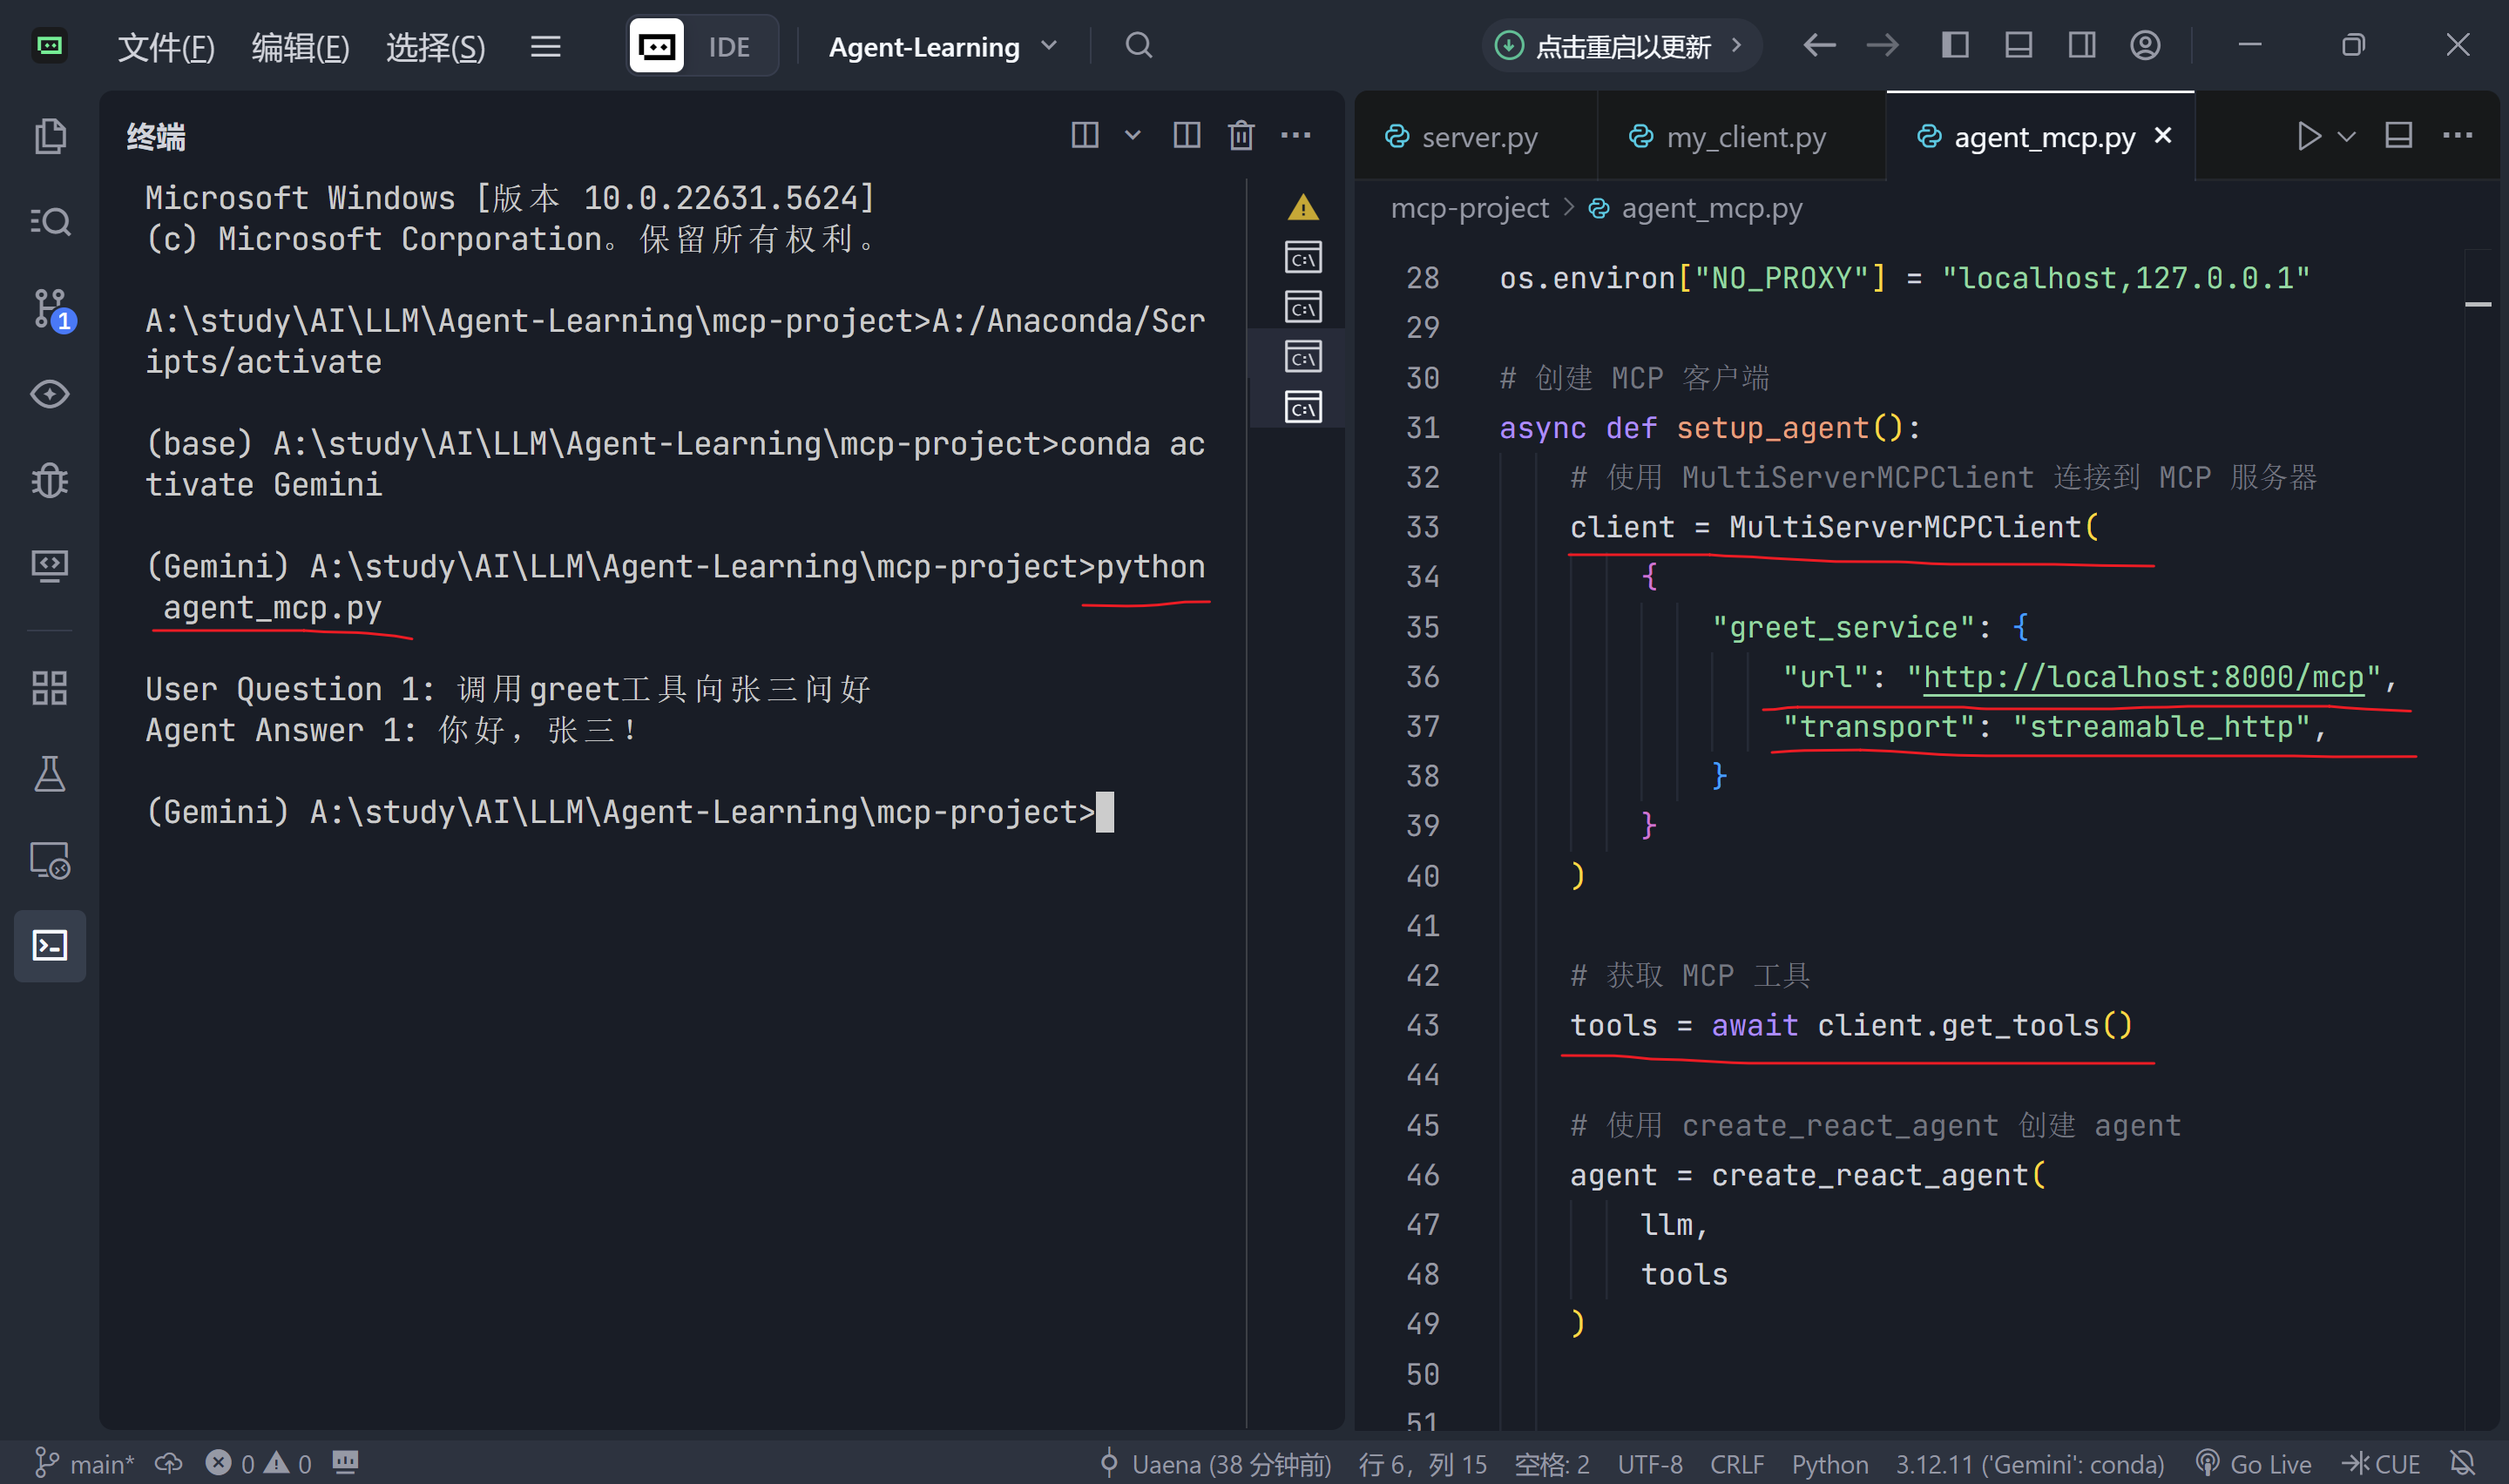